This is a simple ODE system solved with a PINN model using the DeepXDE library.

*In this version, i built my own methods for the calculation of the jacobian and hessian matrices, which also save all computed derivatives and reuse them when needed to save computations, using the tensorflow library.*

<br>

\begin{equation}
\frac{\partial y_1}{\partial t} = y_2 \hspace{1cm} \frac{\partial y_2}{\partial t} = -y_1  \hspace{1cm} t∈[0,10]
\end{equation}
<br>

\begin{equation}
y_1(0) = 0 \hspace{1cm} y_2(0) = 1
\end{equation}



Test losses after 10000 epochs are approximately:

*In accordance to y outputs:* **1.93e-05**, **1.81e-05**

*In accordance to boundary conditions:* **1.80e-06**, **4.22e-08**

*In accordance to the known solution:* **6.99e-03**

In [1]:
# Importing libraries

!pip install deepxde
import deepxde as dde
from deepxde.backend import tf
import numpy as np

     |████████████████████████████████| 122 kB 5.3 MB/s 
     |████████████████████████████████| 100 kB 6.1 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
# Define geometry

geom = dde.geometry.TimeDomain(0, 10)

In [3]:
# Define jacobian method
J = {}

def jacobian(y, x, i = 0, j = 0):

    key = (y.ref(), x.ref())

    if y.shape[1] > 1:
        y = y[:, i : i + 1]

    if key not in J:
        y_gradients = {}
        y_gradients[i] = tf.gradients(y, x)[0]
        J[key] = y_gradients
        print("Key cell created and gradients for y" + repr(i+1) + " added")

    if i not in J[key]:
        J[key][i] = tf.gradients(y, x)[0]
        print("Gradients for y" + repr(i+1) + " added")

    return J[key][i][:, j : j + 1]

In [4]:
# Define hessian method
H = {}

def hessian(y, x, i = 0, j = 0, component = 0):

    key = (y.ref(), x.ref())

    if key not in J:
        grad = jacobian(y, x, component, i)

    if component not in J[key]:
        jacobian(y, x, component, i)

    if key not in H:
        yy_gradients = {}
        grad = J[key][component][:, i : i + 1]
        yy_gradients[component,i] = tf.gradients(grad, x)
        H[key] = yy_gradients

    if (component,i) not in yy_gradients:
        H[key][component, i] = tf.gradients(grad, x)

    return H[key][component, i][:, j : j + 1]

In [5]:
# Define ode system

def ode_system(x,y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    dy1_x = jacobian(y, x, i = 0)
    dy2_x = jacobian(y, x, i = 1)
    return [dy1_x - y2, dy2_x + y1]

In [6]:
# Define initial conditions

def boundary(x, _):
    return np.isclose(x[0], 0)

ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

In [7]:
# Define known solution

def sol(x):
    return np.hstack((np.sin(x), np.cos(x)))

In [8]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode_system, [ic1, ic2], num_domain=100, num_boundary=2, solution = sol, num_test=100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  total_n_samples))


In [9]:
# Create the neural network

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [10]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.087726 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Key cell created and gradients for y1 added
Gradients for y2 added
'compile' took 0.638569 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.36e-01, 3.73e-01, 0.00e+00, 1.00e+00]    [2.40e-01, 3.70e-01, 0.00e+00, 1.00e+00]    [1.14e+00]    
1000      [8.68e-03, 7.80e-03, 3.22e-09, 3.81e-04]    [9.12e-03, 7.38e-03, 3.22e-09, 3.81e-04]    [7.90e-01]    
2000      [6.39e-03, 4.94e-03, 1.27e-06, 1.60e-04]    [6.52e-03, 4.82e-03, 1.27e-06, 1.60e-04]    [6.56e-01]    
3000      [3.71e-03, 3.94e-03, 1.46e-06, 8.04e-05]    [3.81e-03, 3.84e-03, 1.46e-06, 8.04e-05]    [5.09e-01]    
4000      [1.89e-03, 2.40e-03, 1.35e-07, 3.95e-05]    [1.95e-03, 2.23e-03, 1.35e-07, 3.95e-05]    [3.60e-01]    
5000      [6.96e-04, 8.68e-04, 1.62e-06, 8.91e-06]    [7.06e-04, 6.82e-04, 1.62e-06, 8.91e-06]    [1.89e-01]    
6000      [1.64e-04, 2.69e-04, 2.23e-07, 1.58e-06]    [1.62e-04, 1.85e

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


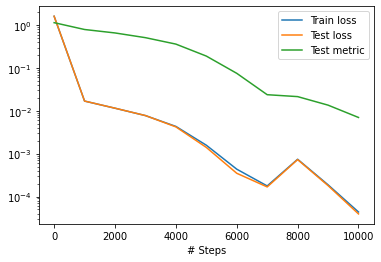

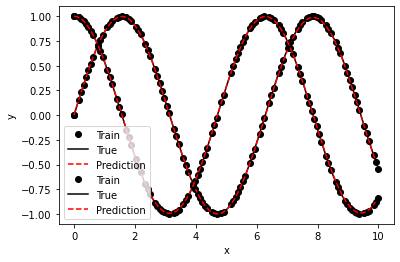

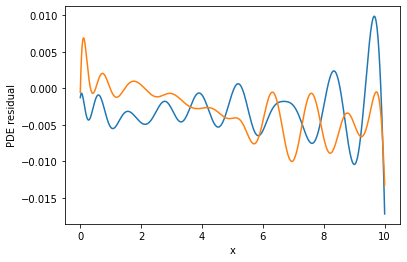

In [14]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Define a random uniform interval of 1000 points to predict.
x = geom.uniform_points(1000, True)

# Make predictions
y = model.predict(x, operator=ode_system)

# Plot predictions
plt.figure()
plt.plot(x, y[0])
plt.plot(x, y[1])
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()